### Imports

In [1]:
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

## Display function

In [2]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by=['fpr','tpr']).reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [3]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Calculate Statistics function

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





In [6]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

## Data1: QDA regression

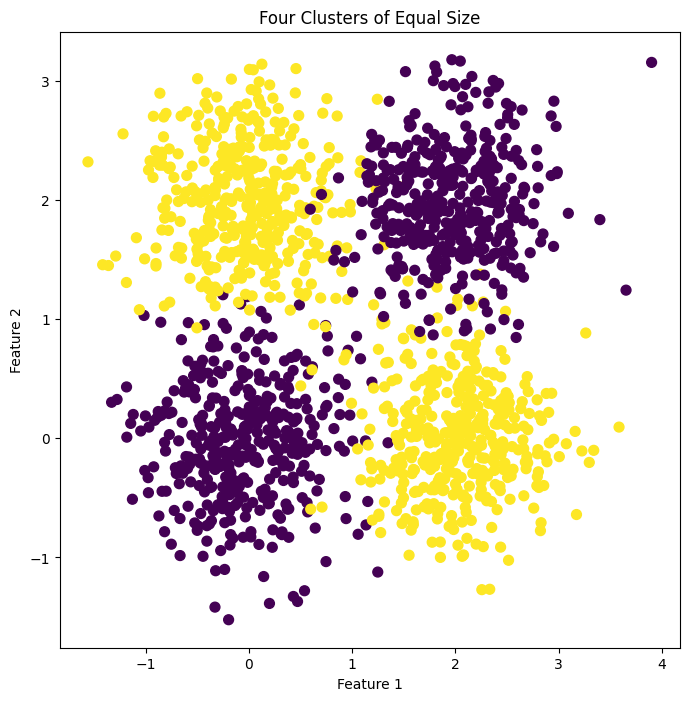

Training data shape: (1000, 2), (1000,)
Test data shape: (600, 2), (600,)


In [7]:
from sklearn.model_selection import KFold
import torch
import torch.utils.data as data

train_data, test_data, val_data = generate_data("data1")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)





### Oversampling

In [8]:
import numpy as np
from collections import Counter
# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed

# --- This block generates the list of ratios for your experiment ---
def generate_ratios(train_data):
    # 1. Get original class counts from your train_dataset

    # --- Initial Data Analysis ---
    counter = Counter(train_data[:, -1])  # Assuming the last column is the class label
    Class0_initial = counter.get(0, 0)
    Class1_initial = counter.get(1, 0)


    class_ratio_low = 0.1   
    class_ratio_high = 100.0 
    num_points_below = 50 
    num_points_above = 50 

    if Class1_initial == 0 and Class0_initial == 0:
        print("ERROR: Both classes have zero samples initially. Cannot proceed.")
        alpha_target_actual_values = [] 
        current_class_ratio = 1.0
    elif Class1_initial == 0:
        current_class_ratio = np.inf 
    else:
        current_class_ratio = Class0_initial / Class1_initial

    # ... (alpha_target_actual_values generation - same robust version) ...
    alpha_target_list = []
    if Class0_initial > 0 or Class1_initial > 0: 
        if current_class_ratio > 0 and not np.isinf(current_class_ratio): 
            alpha_target_list.append(current_class_ratio)
        _safe_class_ratio_low = max(class_ratio_low, EPSILON)
        if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio): 
            try:
                alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
                alpha_target_list.extend(alpha_b)
            except ValueError: pass
        if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio): 
            try:
                _start_geom_above = max(current_class_ratio, _safe_class_ratio_low) 
                if class_ratio_high > _start_geom_above:
                    alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                    if not np.isclose(_start_geom_above, current_class_ratio) and current_class_ratio >=_safe_class_ratio_low and current_class_ratio <= class_ratio_high :
                        alpha_target_list.append(current_class_ratio)
                    alpha_target_list.extend(alpha_a)
                elif np.isclose(class_ratio_high, _start_geom_above):
                    alpha_target_list.append(class_ratio_high)
            except ValueError: pass
        if not alpha_target_list and (Class0_initial > 0 or Class1_initial > 0): 
            if not np.isinf(current_class_ratio) and current_class_ratio > 0:
                alpha_target_list.append(current_class_ratio)
            else: 
                alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
        alpha_target_actual_values = np.unique(alpha_target_list)
        alpha_target_actual_values = np.sort(alpha_target_actual_values[alpha_target_actual_values >= 0]) 
        alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low] 
        alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
        if not alpha_target_actual_values.size and (Class0_initial > 0 or Class1_initial > 0) : 
            if not np.isinf(current_class_ratio) and current_class_ratio > _safe_class_ratio_low and current_class_ratio < class_ratio_high:
                alpha_target_actual_values = np.array([current_class_ratio])
            else: 
                alpha_target_actual_values = np.array([(_safe_class_ratio_low + class_ratio_high)/2.0])


    print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio if Class1_initial > 0 else 'N/A'}")
    print(f"INFO: Target ratios (w values): {alpha_target_actual_values}")
    print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
    print(f"INFO: Standard deviation of synthetic samples will NOT be modified after generation.")

    return alpha_target_actual_values, Class0_initial, Class1_initial

In [9]:
import numpy as np
from collections import Counter


def oversample_dataset_KDE(Class0_initial, Class1_initial, alpha_target, train_data):
    """
    Oversamples a dataset to a target ratio using a KDE-like method.
    This version contains fixes for shape errors when no samples are generated.
    """
    # --- Determine Oversampling Strategy ---
    oversampled_class_label_by_strategy = -1
    initial_count_of_oversampled_class = -1
    final_count_of_oversampled_class = -1

    if Class1_initial == 0 and Class0_initial > 0:
        current_class_ratio = np.inf
    elif Class1_initial == 0 and Class0_initial == 0:
        current_class_ratio = 1.0 # Or some other neutral value
    else:
        current_class_ratio = Class0_initial / Class1_initial

    # Decide which class to oversample or if we should do nothing
    if abs(alpha_target - current_class_ratio) < EPSILON:
        # Ratios are the same, do nothing
        initial_count_of_oversampled_class = Class1_initial # Placeholder
        final_count_of_oversampled_class = Class1_initial   # Placeholder
    elif alpha_target > current_class_ratio:
        # Target has more C0 relative to C1 -> Oversample C0
        oversampled_class_label_by_strategy = 0
        initial_count_of_oversampled_class = Class0_initial
        final_count_of_oversampled_class = int(round(Class1_initial * alpha_target))
    else: # alpha_target < current_class_ratio
        # Target has more C1 relative to C0 -> Oversample C1
        oversampled_class_label_by_strategy = 1
        initial_count_of_oversampled_class = Class1_initial
        final_count_of_oversampled_class = int(round(Class0_initial / alpha_target))

    num_synthetic_to_generate = max(0, final_count_of_oversampled_class - initial_count_of_oversampled_class)
    print(f"  INFO: Strategy: Oversample class {oversampled_class_label_by_strategy} from {initial_count_of_oversampled_class} to {final_count_of_oversampled_class} (generating {num_synthetic_to_generate} samples).")


    # --- KDE-like Synthetic Sample Generation ---
    if num_synthetic_to_generate > 0:
        print(f"  INFO: Using KDE-like generator. Perturbation sigma: {SIGMA_KDE_PERTURBATION}")
        X_new_synthetic = []
        y_new_synthetic = []

        indices_class = np.where(train_data[:, -1] == oversampled_class_label_by_strategy)[0]
        
        if len(indices_class) > 0:
            for _ in range(num_synthetic_to_generate):
                idx_star = np.random.choice(indices_class)
                X_star = train_data[idx_star, :-1]
                epsilon_noise = np.random.randn(*X_star.shape)
                X_prime = X_star + SIGMA_KDE_PERTURBATION * epsilon_noise
                X_new_synthetic.append(X_prime)
                y_new_synthetic.append(oversampled_class_label_by_strategy)

            X_new_synthetic_arr = np.array(X_new_synthetic)
            y_new_synthetic_arr = np.array(y_new_synthetic)
            X_resampled = np.vstack((train_data[:, :-1], X_new_synthetic_arr))
            y_resampled = np.concatenate((train_data[:, -1], y_new_synthetic_arr))
            resampled_counts = Counter(y_resampled)
            print(f"  INFO: KDE-like generation complete. New C0={resampled_counts.get(0,0)}, C1={resampled_counts.get(1,0)}")
        else:
             # This can happen if the class to oversample has 0 members
            print("  WARNING: Cannot generate samples for a class with 0 members. Returning original data.")
            X_resampled = train_data[:, :-1]
            y_resampled = train_data[:, -1]

    else: # num_synthetic_to_generate is 0
        print("  INFO: No synthetic samples were required or generated.")
        # --- THIS IS THE CRITICAL FIX ---
        # Correctly slice the original data instead of copying the whole array
        X_resampled = train_data[:, :-1]
        y_resampled = train_data[:, -1]
        # ----------------------------

    return X_resampled, y_resampled

### Regular training

In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
# Quadratic Discriminant Analysis
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)

#calculate ROC results
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
results_original_roc = {"fpr": fpr_roc, "tpr": tpr_roc, "thresholds": threshold_roc, "name": "Quadratic Discriminant Analysis", "auc": auc(fpr_roc, tpr_roc), "model": clf}

## Oversampling ROC curve

In [11]:


#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds 
list_folds_best_models = []  # List to store best models from all folds

list_weighted_clfs = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage

    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")
    X_train_fold = train_data[train_ids][:, :-1]
    y_train_fold = train_data[train_ids][:, -1]
    X_test_fold = train_data[val_ids][:, :-1]
    y_test_fold = train_data[val_ids][:, -1]
    alpha_target_actual_values, Class0_initial, Class1_initial  = generate_ratios(np.c_[X_train_fold, y_train_fold])  # Combine features and labels for ratio generation
    for w_idx, w in enumerate(alpha_target_actual_values):
        print(f"\n--- Processing target ratio w ({w_idx+1}/{len(alpha_target_actual_values)}): {w:.4f} ---")
        X_train_resampled, y_train_resampled = oversample_dataset_KDE(Class0_initial, Class1_initial, w, np.c_[X_train_fold, y_train_fold])

        clf_weighted = QuadraticDiscriminantAnalysis()
        clf_weighted.fit(X_train_resampled, y_train_resampled)

        res = get_fpr_tpr(clf_weighted, X_test_fold, y_test_fold, threshold=0.5)

        array_of_all_fprs, array_of_all_tprs, threshold_vals = roc_curve(y_test_fold, clf_weighted.predict_proba(X_test_fold)[:, 1])

        current_result = {
            "model": clf_weighted,
            "fpr": res["fpr"],
            "tpr": res["tpr"],
            "threshold": 0.5,
            "full_roc": {"fpr": array_of_all_fprs, "tpr": array_of_all_tprs, "thresholds": threshold_vals},
        }
        list_weighted_clfs.append(current_result)
        best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)

--- Starting Fold 1/4 ---
INFO: Initial C0=372, C1=378, Ratio(0/1): 0.9841269841269841
INFO: Target ratios (w values): [  0.1          0.10467935   0.10957767   0.11470519   0.12007265
   0.12569127   0.13157281   0.13772956   0.14417441   0.15092084
   0.15798295   0.16537553   0.17311403   0.18121465   0.18969432
   0.19857078   0.2078626    0.21758923   0.22777099   0.2384292
   0.24958614   0.26126515   0.27349066   0.28628825   0.29968468
   0.31370798   0.32838748   0.34375389   0.35983934   0.37667748
   0.39430355   0.4127544    0.43206862   0.45228663   0.47345071
   0.49560514   0.51879624   0.54307254   0.56848481   0.59508621
   0.62293239   0.65208158   0.68259477   0.71453578   0.74797142
   0.78297163   0.81960962   0.85796204   0.8981091    0.94013477
   0.98412698   1.08145706   1.18841307   1.30594702   1.43510507
   1.57703684   1.73300566   1.90439977   2.09274474   2.29971702
   2.52715884   2.77709464   3.05174906   3.35356679   3.68523426
   4.04970362   4.450218

  INFO: KDE-like generation complete. New C0=372, C1=3720

--- Processing target ratio w (2/100): 0.1047 ---
  INFO: Strategy: Oversample class 1 from 378 to 3554 (generating 3176 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=372, C1=3554

--- Processing target ratio w (3/100): 0.1096 ---
  INFO: Strategy: Oversample class 1 from 378 to 3395 (generating 3017 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=372, C1=3395

--- Processing target ratio w (4/100): 0.1147 ---
  INFO: Strategy: Oversample class 1 from 378 to 3243 (generating 2865 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=372, C1=3243

--- Processing target ratio w (5/100): 0.1201 ---
  INFO: Strategy: Oversample class 1 from 378 to 3098 (generating 2720 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: 

In [12]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Save the data
save_to_pickle(list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader, filename='pickle/QDA_data1_oversampling.pkl')




Data saved to pickle/QDA_data1_oversampling.pkl


{'best_models': [[{'model': 'original_baseline',
    'fpr': np.float64(0.0),
    'tpr': np.float64(0.8466666666666667),
    'threshold': np.float64(0.7630483137357177)},
   {'model': 'original_baseline',
    'fpr': np.float64(0.0033333333333333335),
    'tpr': np.float64(0.8833333333333333),
    'threshold': np.float64(0.6845288757408253)},
   {'model': 'original_baseline',
    'fpr': np.float64(0.006666666666666667),
    'tpr': np.float64(0.9033333333333333),
    'threshold': np.float64(0.6492875643006866)},
   {'model': QuadraticDiscriminantAnalysis(),
    'fpr': np.float64(0.0078125),
    'tpr': np.float64(0.9426229508196722),
    'threshold': np.float64(0.2178796910184315)},
   {'model': 'original_baseline',
    'fpr': np.float64(0.016666666666666666),
    'tpr': np.float64(0.9433333333333334),
    'threshold': np.float64(0.5832519318860079)},
   {'model': 'original_baseline',
    'fpr': np.float64(0.023333333333333334),
    'tpr': np.float64(0.95),
    'threshold': np.float64(0.54

# Load pickle

In [1]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Load the data
list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader = load_from_pickle(filename='pickle/QDA_data1_oversampling.pkl')

Data loaded successfully.


### Ensemble prediction using voting

In [2]:
import numpy as np

# --- Loop through all the FPR values to generate the ensemble ROC curve ---



results_tuple, prior_proba = predict_ensemble_and_evaluate(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader)

ensemble_results_soft = results_tuple['soft_voting']
ensemble_results_hard = results_tuple['hard_voting']
misclassification_risk = results_tuple['misclassification_risk']






Creating a single ensemble from 45 models across all folds.
Extracting full dataset...
Getting predictions from all models...


## Calculate Neyman Pearson ROC curve

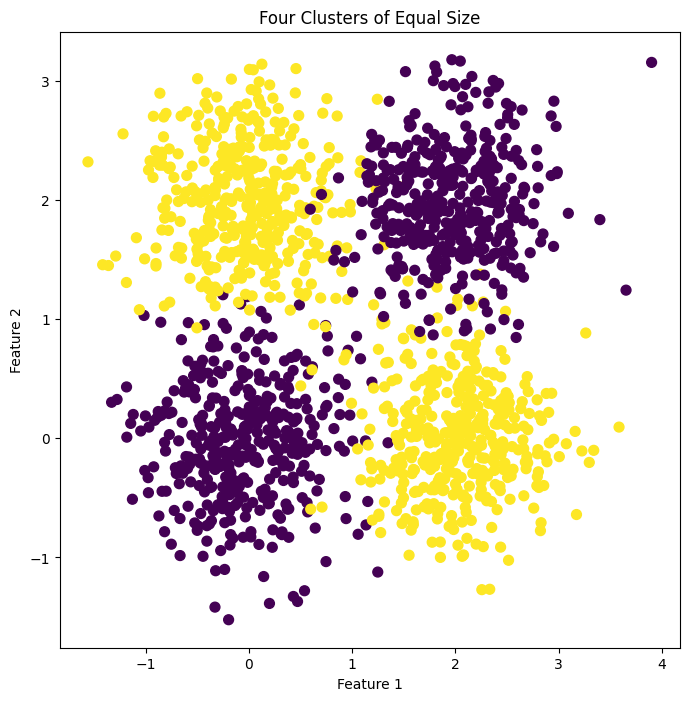

Training data shape: (1000, 2), (1000,)
Test data shape: (600, 2), (600,)
Generating constrained ROC curve (Neyman-Pearson Simulation)...
Phase 1 Complete. Model trained and scores generated.

Phase 2: Calculating cutoffs for all alphas without re-training...
Sample size is too small for the given alpha. Try a larger alpha.
Alpha 0.00 (1/51): No valid cutoff found (sample size may be too small).
Alpha 0.02 (2/51): FPR=0.003, TPR=0.883
Alpha 0.04 (3/51): FPR=0.010, TPR=0.927
Alpha 0.06 (4/51): FPR=0.033, TPR=0.963
Alpha 0.08 (5/51): FPR=0.047, TPR=0.970
Alpha 0.10 (6/51): FPR=0.083, TPR=0.977
Alpha 0.12 (7/51): FPR=0.107, TPR=0.977
Alpha 0.14 (8/51): FPR=0.157, TPR=0.990
Alpha 0.16 (9/51): FPR=0.180, TPR=0.990
Alpha 0.18 (10/51): FPR=0.200, TPR=0.993
Alpha 0.20 (11/51): FPR=0.217, TPR=0.993
Alpha 0.22 (12/51): FPR=0.243, TPR=0.993
Alpha 0.24 (13/51): FPR=0.273, TPR=0.993
Alpha 0.26 (14/51): FPR=0.303, TPR=0.997
Alpha 0.28 (15/51): FPR=0.337, TPR=0.997
Alpha 0.30 (16/51): FPR=0.353, TPR=

In [11]:
import os
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, auc
import numpy as np
import torch
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from nproc import npc
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4

train_data, test_data, val_data = generate_data("data1")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
print("Generating constrained ROC curve (Neyman-Pearson Simulation)...")

npc_instance = npc()

model = QuadraticDiscriminantAnalysis()

result = npc_instance.npc(
    x=X_train, 
    y=y_train, 
    method="", # Leave blank to use the provided model
    model=model,
    rand_seed=42
)

# Extract the essential, one-time results
# The structure is result[fits][split_index][element_index]
fit_results = result[0][0]
final_model = fit_results[0] # The trained model
y_test_calib = fit_results[1]       # The labels from the calibration set
y_decision_values = fit_results[2]  # The scores from the single trained model
initial_sign = fit_results[4]       # The sign indicating score direction

print("Phase 1 Complete. Model trained and scores generated.")

# --- 3. Phase 2: Calculate All ROC Points Efficiently ---
print("\nPhase 2: Calculating cutoffs for all alphas without re-training...")

# Define the FPR constraints (alphas) we want to target
alphas = np.linspace(0, 1, 51)
roc_points = []

# Get the model's scores on the completely separate test set
y_test_scores = final_model.predict_proba(X_test)[:, 1]

# If the sign is True, it means lower scores are better for class 1.
# The npc_core function expects higher scores to be better, so we invert them once.
if initial_sign:
    y_decision_values = -y_decision_values
    y_test_scores = -y_test_scores

for i, alpha in enumerate(alphas):
    # Call ONLY the fast npc_core function
    core_result = npc_instance.npc_core(
        y_test=y_test_calib,
        y_decision_values=y_decision_values,
        alpha=alpha,
        delta=0.05,
        n_cores=1
    )
    
    if not core_result or core_result[6] == True: # core_result[6] is n_small flag
        print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): No valid cutoff found (sample size may be too small).")
        continue

    # Get the optimal cutoff for this specific alpha
    cutoff = core_result[0]

    # Manually apply the cutoff to the saved scores to get predictions
    # Note: We already handled the sign, so higher score is always better here.
    y_pred = (y_test_scores >= cutoff).astype(int)

    # Calculate TPR and FPR for this point
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    current_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    current_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    roc_points.append({'fpr': current_fpr, 'tpr': current_tpr})
    print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): FPR={current_fpr:.3f}, TPR={current_tpr:.3f}")

# --- 4. Process and Plot the Results ---
# Remove duplicate points
unique_points_dict = {(p['fpr'], p['tpr']): p for p in roc_points}
constrained_points = list(unique_points_dict.values())
constrained_points = sorted(constrained_points, key=lambda x: x['fpr'])

In [12]:
from predict_ensemble_and_evaluate import save_to_pickle_constrained_roc

# Save the constrained ROC curve results
save_to_pickle_constrained_roc(constrained_points, filename='pickle/QDA_Data1_NP_roc_curve.pkl')

Constrained ROC curve points saved to pickle/QDA_Data1_NP_roc_curve.pkl


## Load NP curve pickle

In [3]:
from predict_ensemble_and_evaluate import load_from_pickle_constrained_roc

# Load the constrained ROC curve results
constrained_points = load_from_pickle_constrained_roc(filename='pickle/QDA_Data1_NP_roc_curve.pkl')

Constrained ROC curve points loaded from pickle/QDA_Data1_NP_roc_curve.pkl



--- Plotting all ROC curves for comparison ---


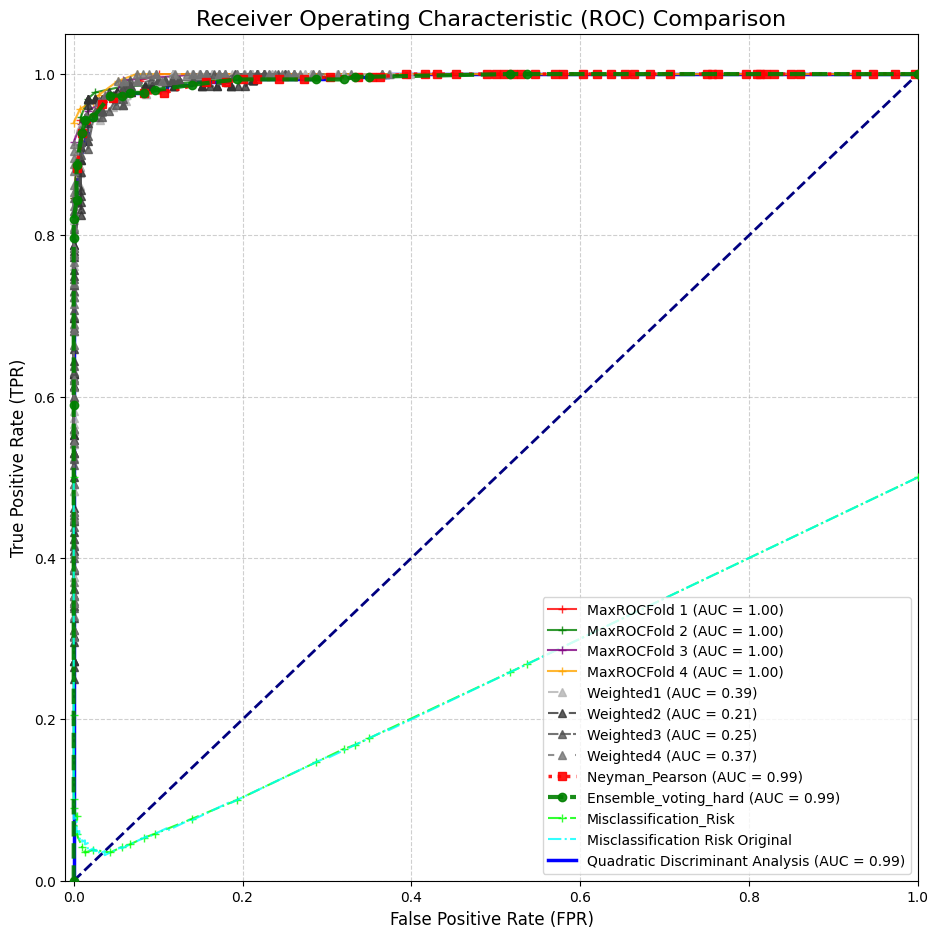

In [4]:

# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(constrained_points)
results_lists.append(ensemble_results_hard)
results_lists.append(misclassification_risk)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    results_original_roc=results_original_roc, plot_name="QDA_oversampling_data1", prior_prob=prior_proba
)